Coronagraph Design
=================

Main goal here is to design the Classic Lyot Coronagraph for the High Contrast Imaging Testbed at the Lab for Adpative Optics. This means we start with a Keck-like aperture, by which we mean an Iris AO and a mask that simulates the secondary obscuration and spiders. 

Simple case as reference : literally just a size 1 circular aperture, with everything considered as ratio. 

Realistic/interesting case : start with our Keck-like/Iris AO+ aperture 

Wild but maybe feasible case : A hybrid Lyot Stop Situation where we invert the Keck pupil. Some very basic tests show this would be great, but can we actually make this easily? Who's to say. 

If along the way this becomes a neat reference for coronagraph design, well I guess that's cool too...

In [1]:
from hcipy import * # I will fix this someday I promise
import matplotlib.pyplot as plt
import numpy as np
from photutils import CircularAperture, CircularAnnulus

In [13]:
# calculate raw contrast at radial annulus cuts -- TODO : redo this in terms of lam/D instead of pix radius
# also make sure these hard coded #s are still good as we may have adjusted the pixel grid...
def calculate_raw_contrast(image_data, max_ref=1):
    
    origin = (192/2, 192/2)
    max_edge = int(192/2)
    annulus_width = lambda_over_d

    ring_edges = np.arange(4, max_edge, 3)
    ring_sums = []

    for ring_edge in range(4, max_edge, 3):
        #print(ring_edge-annulus_width, ring_edge)
        ring = CircularAnnulus(origin, r_in=ring_edge-annulus_width, r_out=ring_edge)
        ring_mask = ring.to_mask(method='center')
        image_ring = ring_mask.multiply(image_data/max_ref)
        ring_sums.append(np.std(image_ring)) # this is std look at this later 
    return ring_edges, ring_sums

# Spin up our coronagraph given some fpm diameter and lyot diameter and whether it's the simple circular or iris
def generate_coronagraph(fpm_diameter, lyot_diameter, plot=False, vmin=-5, vmax=0, aperture_type='iris'):
    
    wavelength = 638e-9
    
    pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
    
    iris_aperture  = evaluate_supersampled(make_iris_aperture(), pupil_grid, 6)
    circular = evaluate_supersampled(circular_aperture(1), pupil_grid, 6)
    aperture = iris_aperture if aperture_type == 'iris' else circular
    
    lyot_mask = evaluate_supersampled(circular_aperture(lyot_diameter*4), pupil_grid, 4)

    pupil_grid = make_pupil_grid(256, 1.5) # this might be totally wrong whoops
    focal_grid = make_focal_grid(8, 12)  # same tho
    prop = FraunhoferPropagator(pupil_grid, focal_grid)

    wf = Wavefront(aperture)
    img_ref = prop(wf).intensity

    fpm_inverse = evaluate_supersampled(circular_aperture(fpm_diameter), focal_grid, 4)
    fpm = fpm_inverse == 0
    lyot_coro = LyotCoronagraph(pupil_grid, fpm)
    lyot_stop = Apodizer(lyot_mask)
    wf = Wavefront(aperture)
    lyot_plane = lyot_coro(wf)
    post_lyot_mask = lyot_stop(lyot_plane)
    img = prop(post_lyot_mask).intensity
    if plot:
        imshow_field(np.log10(img /img_ref.max()), vmin=vmin, vmax=vmax, cmap='inferno')
    return img.shaped, img_ref.max()

# create our Keck-adjascent aperture
def make_iris_aperture():
    segment_flat_diameter = 0.533 # mm 
    segment_gap = 0.015 # mm 
    spider_width = 1*0.00850 #mm DOUBLE CHECK ME
    segment_transmissions = 1.

    segment_circum_diameter = 2 / np.sqrt(3) * segment_flat_diameter #segment circumscribed diameter

    num_rings = 3 #number of full rings of hexagons around central segment

    segment_positions = make_hexagonal_grid(segment_flat_diameter + segment_gap, num_rings)
    segment_positions = segment_positions.subset(lambda grid: ~(circular_aperture(segment_circum_diameter)(grid) > 0))

    segment = hexagonal_aperture(segment_circum_diameter, np.pi / 2)

    spider1 = make_spider_infinite([0, 0], 0, spider_width) # origin, degree, width 
    spider2 = make_spider_infinite([0, 0], 60, spider_width) 
    spider3 = make_spider_infinite([0, 0], 120, spider_width)
    spider4 = make_spider_infinite([0, 0], 180, spider_width)
    spider5 = make_spider_infinite([0, 0], 240, spider_width)
    spider6 = make_spider_infinite([0, 0], 300, spider_width)

    segmented_aperture = make_segmented_aperture(segment, segment_positions, segment_transmissions, return_segments=False)
    
    def func(grid):
        res = segmented_aperture(grid) #* spider1(grid) * spider2(grid) * spider3(grid)* spider4(grid) * spider3(grid)* spider5(grid) * spider6(grid) # * coro(grid)
        return Field(res, grid)
    
    return func 


def make_iris_aperture_no_spiders():
    segment_flat_diameter = 0.533 # mm 
    segment_gap = 0.015 # mm 
    spider_width = 1*0.00850 #mm DOUBLE CHECK ME
    segment_transmissions = 1.

    segment_circum_diameter = 2 / np.sqrt(3) * segment_flat_diameter #segment circumscribed diameter

    num_rings = 3 #number of full rings of hexagons around central segment

    segment_positions = make_hexagonal_grid(segment_flat_diameter + segment_gap, num_rings)
    #segment_positions = segment_positions.subset(lambda grid: ~(circular_aperture(segment_circum_diameter)(grid) > 0))

    segment = hexagonal_aperture(segment_circum_diameter, np.pi / 2)

    spider1 = make_spider_infinite([0, 0], 0, spider_width) # origin, degree, width 
    spider2 = make_spider_infinite([0, 0], 60, spider_width) 
    spider3 = make_spider_infinite([0, 0], 120, spider_width)
    spider4 = make_spider_infinite([0, 0], 180, spider_width)
    spider5 = make_spider_infinite([0, 0], 240, spider_width)
    spider6 = make_spider_infinite([0, 0], 300, spider_width)

    segmented_aperture = make_segmented_aperture(segment, segment_positions, segment_transmissions, return_segments=False)
    

    
    def func(grid):
        res = segmented_aperture(grid) #* spider1(grid) * spider2(grid) * spider3(grid)* spider4(grid) * spider3(grid)* spider5(grid) * spider6(grid) # * coro(grid)
        return Field(res, grid)
    
    return func

One extended demo of what's going on here
----------------------------------------------------

Okay, before we dive into comparing lots of different cases I want to work through one example, which is going to be the complex Keck-like aperture and something that seems vaguely reasonable

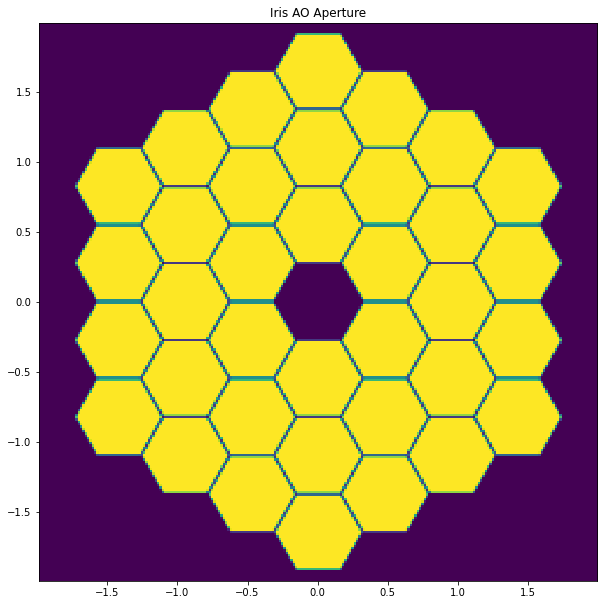

In [6]:
# Set up the pupil grid
pupil_grid_diameter = 4
num_pupil_pixels = 240
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
iris_aperture  = evaluate_supersampled(make_iris_aperture(), pupil_grid, 6)
fig = plt.subplots(figsize=(10,20))
plt.title('Iris AO Aperture')
imshow_field(iris_aperture)

In [ ]:
focal_grid = make_focal_grid(8, 12) 
prop = FraunhoferPropagator(pupil_grid, focal_grid)
wf = Wavefront(iris_aperture)
img_ref = prop(wf).intensity

lyot_diameter = .95
fpm_diameter = 4.75
lyot_mask = evaluate_supersampled(circular_aperture(lyot_diameter*4), pupil_grid, 4)
fpm_inverse = evaluate_supersampled(circular_aperture(fpm_diameter), focal_grid, 4)
fpm = fpm_inverse == 0
lyot_coro = LyotCoronagraph(pupil_grid, fpm)
lyot_stop = Apodizer(lyot_mask)

wf = Wavefront(iris_aperture)
lyot_plane = lyot_coro(wf)
post_lyot_mask = lyot_stop(lyot_plane)
img = prop(post_lyot_mask).intensity
ring_edges, ring_sums = calculate_raw_contrast(img.shaped, np.max(img.shaped))

fig = plt.subplots(figsize=(15,20))
plt.subplot(2, 2, 1)
plt.title('Reference PSF (Focal)')
imshow_field(np.log10(img_ref/img_ref.max()), vmin=-5)

plt.subplot(2, 2, 2)
plt.title('Post FPM (Pupil)')
imshow_field(lyot_plane.intensity)


plt.subplot(2, 2, 3)
plt.title('Post Lyot Stop (Focal)')
imshow_field(np.log10(img/img_ref.max()), vmin=-5)

plt.subplot(2, 2, 4)
plt.plot(ring_edges, ring_sums)
plt.title('Raw Contrast')
plt.xlabel('Pixel Radius')

In [ ]:
# Set up the pupil grid
pupil_grid_diameter = 1.1
num_pupil_pixels = 240
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
circle_aperture =  circular = evaluate_supersampled(circular_aperture(1), pupil_grid, 6)
fig = plt.subplots(figsize=(10,20))
plt.title('Typical Circular Aperture')
imshow_field(circle_aperture)

In [ ]:
focal_grid = make_focal_grid(8, 12) 
prop = FraunhoferPropagator(pupil_grid, focal_grid)
wf = Wavefront(circle_aperture)
img_ref = prop(wf).intensity

lambda_over_d = wavelength / 1e3

lyot_diameter = .95
fpm_diameter = 8
lyot_mask = evaluate_supersampled(circular_aperture(lyot_diameter*1), pupil_grid, 4)
fpm_inverse = evaluate_supersampled(circular_aperture(fpm_diameter), focal_grid, 4)
fpm = fpm_inverse == 0
lyot_coro = LyotCoronagraph(pupil_grid, fpm)
lyot_stop = Apodizer(lyot_mask)

wf = Wavefront(circle_aperture)
lyot_plane = lyot_coro(wf)
post_lyot_mask = lyot_stop(lyot_plane)
img = prop(post_lyot_mask).intensity
ring_edges, ring_sums = calculate_raw_contrast(img.shaped, np.max(img.shaped))

fig = plt.subplots(figsize=(15,20))
plt.subplot(2, 2, 1)
plt.title('Reference PSF (Focal)')
imshow_field(np.log10(img_ref/img_ref.max()), vmin=-5)

plt.subplot(2, 2, 2)
plt.title('Post FPM (Pupil)')
imshow_field(lyot_plane.intensity)


plt.subplot(2, 2, 3)
plt.title('Post Lyot Stop (Focal)')
imshow_field(np.log10(img/img_ref.max()), vmin=-5)

plt.subplot(2, 2, 4)
plt.plot(ring_edges, ring_sums)
plt.title('Raw Contrast')
plt.xlabel('Pixel Radius')

Now For Some Attempt at Optimizing?
-----------------------------------

Okay, now we attempt to step through and pick some sort of optimized FPM/LS

In [ ]:
#fpm_range = np.arange(3.75, 5, .25)
fpm_d = 4.75
lyot_range = np.arange(.9, 1.01, .005)

min_heat_map, max_heat_map, med_heat_map = np.zeros((len(lyot_range))), np.zeros((len(lyot_range))), np.zeros((len(lyot_range)))

plt.clf()
fig = plt.subplots(figsize=(10,10))

for n, lyot_d in enumerate(lyot_range):
    intensity_data, max_val = generate_coronagraph(fpm_d, lyot_d)
    ring_edges, ring_sums = calculate_raw_contrast(intensity_data, max_val)
    plt.plot(ring_edges, ring_sums)
    min_heat_map[n] = np.min(ring_sums)
    max_heat_map[n] = np.max(ring_sums)
    med_heat_map[n] = np.median(ring_sums)

plt.yscale('log')
plt.xlabel('Pixel radius')
plt.ylabel('Raw Contrast')

In [ ]:
fig = plt.subplots(figsize=(20,5))
ax = plt.subplot(1, 3, 1)
plt.title('Min Heat Map')
plt.plot(lyot_range, min_heat_map) #, vmax=3e-7)
#plt.ylabel('FPM Diameter')
#ax.set_yticks(np.arange(0, m+1, 1))
#ax.set_yticklabels(fpm_range)
plt.xlabel('Lyot Diameter / full')

plt.subplot(1, 3, 2)
plt.title('Max Heat Map')
plt.plot(lyot_range, max_heat_map) #, vmax=8e-5)
#plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Med Heat Map')
plt.plot(lyot_range, med_heat_map) #, vmax=7e-6)
#plt.axis('off')

In [ ]:
wavelength = 638 # nm
diameter = 3.5e3 # nm
lambda_over_d = wavelength/diameter
lambda_over_d
fpm_d = 1.5 * lambda_over_d

In [ ]:
imshow_field(iris_aperture)

In [18]:
from astropy.io import fits

In [ ]:
iris_aperture.shaped
hdu = fits.PrimaryHDU(iris_aperture.shaped)
hdu.writeto('iris_aperture.fits')

In [ ]:
hdu.writeto('iris_aperture.fits')

In [ ]:
pupil_grid_diameter = 4
num_pupil_pixels = 240
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
iris_aperture  = evaluate_supersampled(make_iris_aperture_no_spiders(), pupil_grid, 6)

In [ ]:
imshow_field(iris_aperture)
iris_aperture.shaped
hdu = fits.PrimaryHDU(iris_aperture.shaped)
hdu.writeto('iris_aperture_no_spiders.fits')

In [8]:
def make_iris_aperture_no_spiders_no_secondary():
    segment_flat_diameter = 0.533 # mm 
    segment_gap = 0.015 # mm 
    spider_width = 1*0.00850 #mm DOUBLE CHECK ME
    segment_transmissions = 1.

    segment_circum_diameter = 2 / np.sqrt(3) * segment_flat_diameter #segment circumscribed diameter

    num_rings = 3 #number of full rings of hexagons around central segment

    segment_positions = make_hexagonal_grid(segment_flat_diameter + segment_gap, num_rings)
   # segment_positions = segment_positions.subset(lambda grid: ~(circular_aperture(segment_circum_diameter)(grid) >= 0))

    segment = hexagonal_aperture(segment_circum_diameter, np.pi / 2)


    segmented_aperture = make_segmented_aperture(segment, segment_positions, segment_transmissions, return_segments=False)
    

    def func(grid):
        res = segmented_aperture(grid) 
        return Field(res, grid)

In [14]:
pupil_grid_diameter = 4
num_pupil_pixels = 240
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
iris_aperture  = evaluate_supersampled(make_iris_aperture_no_spiders(), pupil_grid, 6)

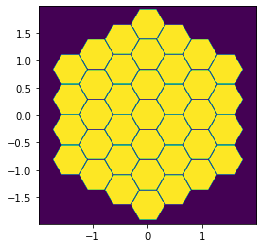

In [19]:
imshow_field(iris_aperture)
iris_aperture.shaped
hdu = fits.PrimaryHDU(iris_aperture.shaped)
hdu.writeto('iris_aperture_no_spiders_no_secondary.fits')